<a href="https://colab.research.google.com/github/yesiltepe-hidir/NVAE/blob/master/Deterministic_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/yesiltepe-hidir/NVAE.git
!pip install tensorboardX

In [1]:
%cd NVAE 

/content/NVAE


In [2]:
!python3 train.py --dataset mnist --epochs 4 --root /content/NVAE  --data /content/NVAE --save /eval- --batch_size 200

Experiment dir : /content/NVAE/eval-
starting in debug mode
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
MULT:  1.0
len log norm: 128
len bn: 92
07/17 01:14:10 PM (Elapsed: 00:00:02) args = Namespace(ada_groups=False, arch_instance='res_mbconv', batch_size=200, cont_training=False, data='/content/NVAE', dataset='mnist', distributed=True, embedding_weight=0.0001, epochs=4, fast_adamax=False, global_rank=0, kl_anneal_portion=0.3, kl_const_coeff=0.0001, kl_const_portion=0.0001, learning_rate=0.01, learning_rate_min=0.0001, local_rank=0, master_address='127.0.0.1', min_groups_per_scale=

In [3]:
# Import libraries
import argparse
import torch
import torch.nn as nn
import numpy as np
import os

import torch.distributed as dist
from torch.multiprocessing import Process
from torch.cuda.amp import autocast, GradScaler

from model import AutoEncoder
from thirdparty.adamax import Adamax
import utils
import datasets

from fid.fid_score import compute_statistics_of_generator, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3

import matplotlib.pyplot as plt

In [4]:
# Get args
PATH = 'eval-/checkpoint.pt'
checkpoint = torch.load(PATH)
args = checkpoint['args']

In [5]:
# Create Model
writer = utils.Writer(args.global_rank, args.save)
arch_instance = utils.get_arch_cells(args.arch_instance)
model = AutoEncoder(args, writer, arch_instance)
model = model.cuda()

MULT:  1.0
len log norm: 128
len bn: 92


In [6]:
# Load Model
model.load_state_dict(checkpoint['state_dict'])

# Initialize
os.environ['MASTER_ADDR'] = args.master_address
os.environ['MASTER_PORT'] = '6020'
torch.cuda.set_device(args.local_rank)
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=args.num_process_per_node)

In [7]:
# logits = model.sample(4, 1)
# len(logits)
logits = checkpoint['logits']
logits.size()

torch.Size([200, 1, 32, 32])

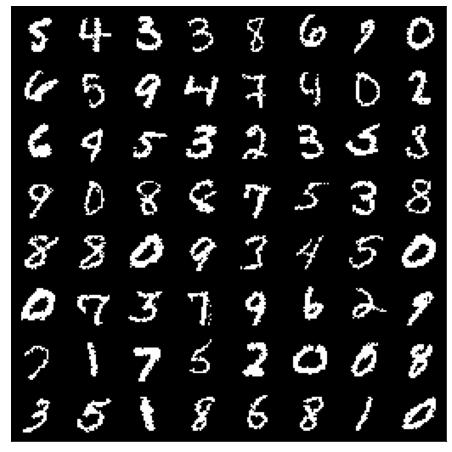

In [8]:
plt.rcParams['figure.figsize'] = (8, 8)
output = model.decoder_output(logits[:64])
output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) else output.sample(t)
output_tiled = utils.tile_image(output_img, 8)
plt.imshow(output_tiled[0].double().cpu().detach().numpy(), cmap='gray')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

In [9]:
output_img.size()

torch.Size([64, 1, 32, 32])